In [79]:
from pypdf import PdfReader
import re
import networkx as nx
import matplotlib.pyplot as plt 
import numpy as np

# Extraction et traitement des données


## On extrait le texte du pdf

In [80]:
reader = PdfReader('Star_Wars_Episode_3_Revenge_Of_The_Sith.pdf')
npages = len(reader.pages)
text = ''
for i in range(npages):
    page = reader.pages[i]
    text += page.extract_text()


## On traite le texte pour diviser le script en scènes

In [81]:
temp = text.split('\n')
data = []

# On localise les scènes
scenes = []
for i in range(len(temp)):
    # George Lucas a oublié de mettre des points à tous les INT et EXT...
    if ("INT" in temp[i] or "EXT" in temp[i]) and "INTERCUT" not in temp[i]:
        scenes.append(i)

# On divise les scènes dans data
for i in range(len(scenes)-1):
    data.append(temp[scenes[i]:scenes[i+1]])
data.append(temp[scenes[-1]:])




## On cherche les personnages parlant dans chaque scène

In [82]:
characters = {}
pattern = r'\b[A-Za-z][A-Za-z0-9\- ]+:'
for i in range(len(data)):
    temp = ''.join(data[i][1:])
    personnages = re.findall(pattern, temp)
    personnages = [personnages[m].upper() for m in range(len(personnages))]
    if i not in characters:
        characters[i] = []
    for personnage in personnages:
        if personnage[:-1] not in characters[i]:
            characters[i].append(personnage[:-1])

## On corrige les fautes de frappe

In [83]:
error = 0
# G-3PO
characters[161].remove('G-3PO')
error += 1
 
# Qui -Gon
characters[221].remove('QUI -GON')
error += 1

# ANAKINN
characters[52].remove('ANAKINN')
error += 1

# Obi-Wan  (avec espace)
characters[85].remove('OBI-WAN ')
error += 1

# Dabth sidious
characters[140].remove('DABTH SIDIOUS')
characters[140].append('DARTH SIDIOUS')
error += 1

# Some errors
characters[7].remove(characters[7][3])
characters[129].remove(characters[129][0])
characters[115].remove(characters[115][0])
characters[104].remove(characters[104][2])
error += 4

for i in characters:
    if 'MACE' in characters[i]:
        characters[i].remove('MACE')
        if "MACE WINDU" not in characters[i]:
            characters[i].append('MACE WINDU')
        error += 1

    if 'MACE WLNDU' in characters[i]:
        characters[i].remove('MACE WLNDU')
        if "MACE WINDU" not in characters[i]:
            characters[i].append('MACE WINDU')
        error += 1

    if 'BAIL' in characters[i]:
        characters[i].remove('BAIL')
        if "BAIL ORGANA" not in characters[i]:
            characters[i].append('BAIL ORGANA')
        error += 1

    if 'DARTH SLDIOUS' in characters[i]:
        characters[i].remove('DARTH SLDIOUS')
        if "DARTH SIDIOUS" not in characters[i]:
            characters[i].append('DARTH SIDIOUS')
        error += 1

print("Nombre d'erreurs (hors fautes de majuscule): ", error)

Nombre d'erreurs (hors fautes de majuscule):  25


# Début du graphe

## Liste d'adjacence

In [84]:
nodes = []
edges = []

for i in characters:
    if len(characters[i]) >= 2:
        edges.append(characters[i])

    for j in characters[i]:
        if j not in nodes:
            nodes.append(j)
            
# sort nodes alphabetically
nodes.sort()
Nnodes = len(nodes)

# Faire la liste d'adjacence
adj = {}
for node in nodes:
    adj[node] = []

# Remplir la liste d'adjacence
for edge in edges:
    for i in range(len(edge)):
        adj[edge[i]] += edge[:i] + edge[i+1:]

## Création du graphe

In [85]:
# Graphe entier
G = nx.Graph()

for i in nodes:
    G.add_node(i)

for i in G.nodes():
    for j in adj[i]:
        if not G.has_edge(i, j):
            G.add_edge(i, j, weight=1)
        else:
            G[i][j]['weight'] += 1


### Plot du graphe

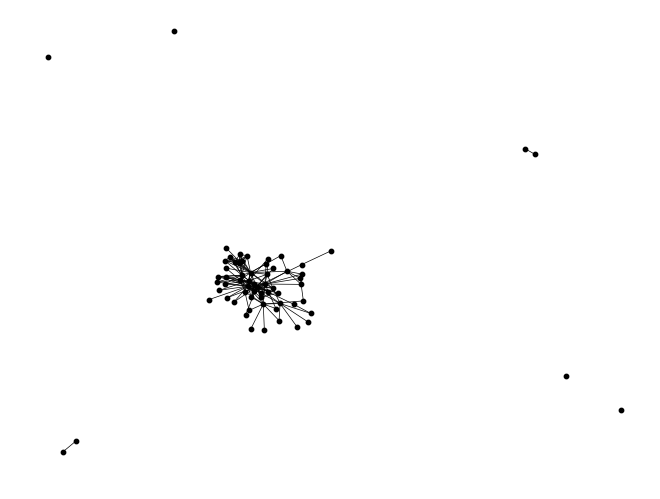

In [87]:
g_draw = G
pos = nx.spring_layout(g_draw)
nx.draw(g_draw, pos, node_color='black', node_size=10, width=0.5)

### Degrees

Text(0.5, 1.0, 'Degree distribution')

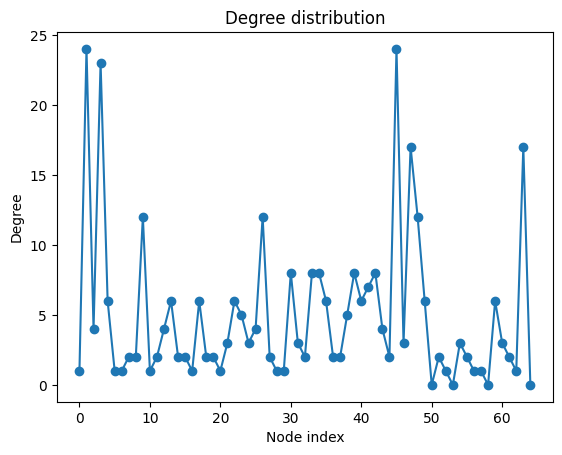

In [88]:
degrees = [G.degree(node) for node in nodes]
plt.plot(degrees,  linestyle='-', marker='o')
plt.xlabel('Node index')
plt.ylabel('Degree')
plt.title('Degree distribution')


Text(0.5, 1.0, 'Degree distribution')

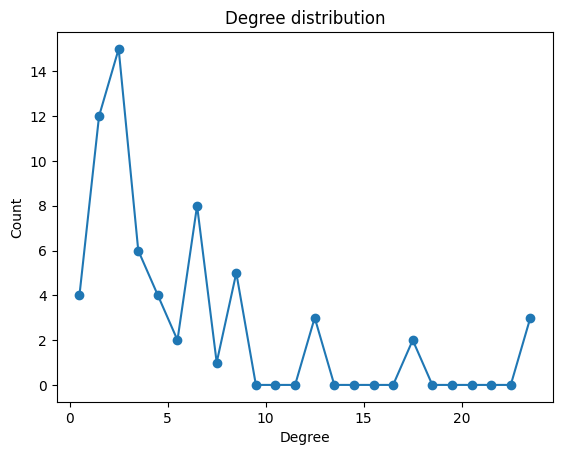

In [89]:
b_width = 1
bins = np.arange(min(degrees), max(degrees)+b_width, b_width)
hist, bins = np.histogram(degrees, bins = bins)
center_bins = [l+b_width/2 for l in bins[:-1]]

plt.plot(center_bins, hist, marker = "o")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree distribution")


## Composantes connexes
Identification des composantes connexes

In [90]:
connect = nx.is_connected(G)
N_connected = nx.number_connected_components(G)
max_connected = max(nx.connected_components(G), key=len)
max_cc = G.subgraph(max_connected)



print("Le graphe est-il connexe ? ", connect)
print("Nombre de composantes connexes : ", N_connected)


Le graphe est-il connexe ?  False
Nombre de composantes connexes :  7


On plot la composante connexe la plus grande

Graph with 57 nodes and 159 edges


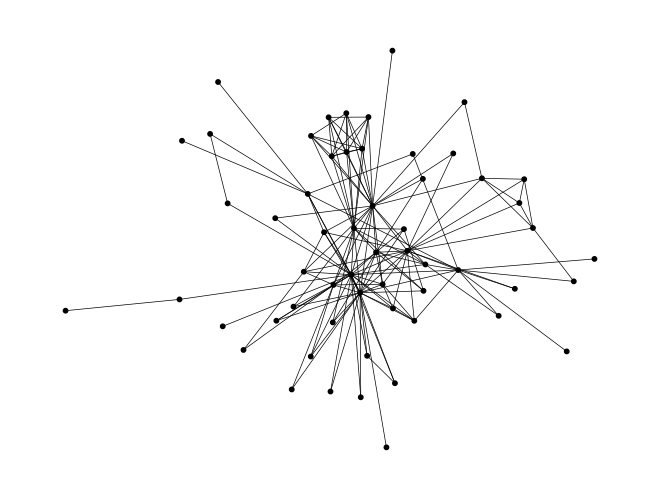

In [91]:
cc_draw = max_cc

color = np.array(["black"] * len(max_cc.nodes()))
pos = nx.spring_layout(cc_draw)
nx.draw(cc_draw, pos, node_color=color, node_size=10, width=0.5)

print(max_cc)

In [92]:
for i in max_cc.nodes():
    print(i, max_cc.degree(i))

ANAKIN 24
AT-ST CLONE SERGEANT 4
BAIL ORGANA 23
BANA BREEMU 6
BATTLE DROID 1
BODYGUARD 2
BODYGUARD I 2
C-3PO 12
CAPTAIN 1
CAPTAIN ANTILLES 2
CAPTAIN TYPHO 4
CHI EEKWAY 6
CLONE CAPTAIN 2
CLONE COMMANDER APPO 2
CLONE COMMANDER BACARA 1
CLONE COMMANDER CODY 6
CLONE COMMANDER GREE 2
CLONE COMMANDER THIRE 2
CLONE PILOT 1
CLONE PILOT 2 3
CLONE SERGEANT 6
CLONE TROOPER 5
COUNT DOOKU 3
CREATURE 4
DARTH SIDIOUS 12
DARTH VADER 2
FANG ZAR 8
FANGZAR 3
FLRESHIP PILOT 2
GENERAL GRIEVOUS 8
GIDDEAN DANU 8
GLDDEAN DANU 6
GUARD 2
JAR JAR 2
KL-ADI-MUNDI 5
MACE WINDU 8
MAS AMEDDA 6
MEDICAL DROID 7
MON MOTHMA 8
MOTEE 4
NUTE GUNRAY 2
OBI-WAN 24
ODD BALL 3
PADME 17
PALPATINE 12
PILOT 6
QUI-GON 2
ROYAL GUARD 1
SUPER BATTLE DROID 3
SUPER BATTLE DROID 1 2
SUPER BATTLE DROID 2 1
SUPER BATTLE DROID G21 1
TERR TANEEL 6
THREEPIO 3
TLON MEDON 2
WRANGLER 1
YODA 17
